# Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, accuracy_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

from scipy import stats

from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import pickle

# Functions

In [2]:
# Calculation of point biserial correlation coefficient for each descriptor in dataset
# N defines number of top ranked descriptors in output
def point_biserial_correlation_data(data_set_in,N):
    
    # select numerical values (descriptors)
    data_set = data_set_in.select_dtypes('number')
    
    # determine correlation coefficiencts
    corr_coeffs_out = [stats.pointbiserialr(data_set_in['RG_binary'],data_set_in[col]).correlation 
               for col in 
               data_set.columns]
    
    p_values_out = [stats.pointbiserialr(data_set_in['RG_binary'],data_set_in[col]).pvalue 
               for col in 
               data_set.columns]

    # plot correlation coefficients
    plt.scatter(np.arange(1,len(corr_coeffs_out)+1),corr_coeffs_out)
    plt.xlabel('Descriptor')
    plt.ylabel('Point biserial r')
    
    # output strongest positive and negative correlation
    print('Strongest postive correlation of ',max(corr_coeffs_out),' for ',data_set.columns[np.nanargmax(corr_coeffs_out)])
    print('Strongest postive correlation of ',min(corr_coeffs_out),' for ',data_set.columns[np.nanargmin(corr_coeffs_out)])
    
    # negative absolute value determined so highest values appear first
    corr_coeffs_abs = -np.abs(corr_coeffs_out)
    
    # define indices of top ranked descriptors for printing
    top_index = corr_coeffs_abs.argsort()[0:N]
    
    # assign output array with N top ranked descriptors to print
    out_array = pd.DataFrame()
    out_array['Descriptor'] = data_set.columns[top_index]
    out_array['Abs (Point biserial r)'] = -corr_coeffs_abs[top_index]
    out_array['p value'] = np.array(p_values_out)[top_index]
    
    print(out_array)

    # output all correlation coefficients
    return corr_coeffs_out,p_values_out

# function to find the best descriptor for a 1-feature logistic regression fit
# N defines number of top ranked descriptors in output
def find_best_classifier(data_set_in,N):
    
    # select numerical values (descriptors)
    data_set = data_set_in.select_dtypes('number')

    # logistic regression model
    clf = LogisticRegression(class_weight='balanced')

    # matrix for scores
    desc_score = []

    # finds logistic regression fit for each descriptor
    for descriptor in data_set.columns:
        clf.fit(data_set_in[descriptor].array.reshape(-1, 1),data_set_in['RG_binary'])
        desc_score.append(balanced_accuracy_score(data_set_in['RG_binary'],clf.predict(data_set_in[descriptor].array.reshape(-1, 1))))
    
    # assign output array of best desecriptors to print
    out_array = pd.DataFrame()
    out_array['Descriptor'] = data_set.columns[np.argsort(desc_score)[:-N:-1]]
    out_array['Balanced accuracy'] = np.array(desc_score)[np.argsort(desc_score)[:-N:-1]]
    print(out_array)
    
    # returns best descriptor, list of descriptors and list of scores
    return data_set.columns[np.argmax(desc_score)],data_set.columns,desc_score

# function to compare binary classification methods for input training X and Y arrays
def comp_bin(X_train,Y_train):
    
    print('   Balanced accuracy (SD)')
    # List of algorithms to test
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DT', DecisionTreeClassifier(class_weight='balanced',random_state=0)))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto',class_weight='balanced')))
    models.append(('MLP', MLPClassifier(max_iter=1000)))
    models.append(('GB',GradientBoostingClassifier(random_state=0)))
    models.append(('RF',RandomForestClassifier(class_weight='balanced',random_state=0)))
    
    # Evaluate each model with 10-fold cross validation
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        names.append(name)
        print('%5s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        
    # Compare classification algorithms
    plt.boxplot(results, labels=names)
    plt.title('Classification Algorithm Comparison')
    plt.ylabel('Balanced accuracy')
    plt.ylim((0,1))
    plt.show()
    
    return results

# function to run recursive feature elimination and output the reduced feature set
# function takes model input features (X_in), model output (y_in), number of features (N), 
# type of feature elimination (RFE or RFECV, sel) and verbosity (verb)
def feat_red(clf,X_in,y_in,N,sel,verb):
    estimator = clf
    if sel == 'RFECV':
        selector = RFECV(estimator, min_features_to_select=N, step=1,verbose=verb, cv = 3)
    else:
        selector = RFE(estimator,n_features_to_select=N,step=1,verbose=verb)
    selector = selector.fit(X_in,y_in)
    feat_out = selector.get_feature_names_out(X_in.columns)
    return feat_out

# runs feat_red function for all numbers of features in array N for input X (features) and y (model output)
# returns an array of feature sets for all specified N
def multi_feat_red(clf,X_in,Y_in,N,sel):
    feat_r = {}
    feat_r[0] = X_in.columns
    j=1
    for i in N:
        feat_r[j]= feat_red(clf,X_in[feat_r[j-1]],Y_in,i,sel,0)
        j=j+1
    return feat_r

# Comparison of feature sets (feat_r) using stratified 10-fold cross validation for a selected classifier (clf)
def feat_comp(clf,feat_r,X_train,Y_train,N_max):
    
    # output headers
    print('           Balanced accuracy')
    print(' i     N    Mean      (SD)')
    
    # defining array for results
    results = []
    
    for i in feat_r:
        
        # selecting columns from X_train corresponding to each feature set
        X_train2 = X_train[feat_r[i]]
        
        # finding balanced accuracy scores for stratified 10-fold cross validation 
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(clf, X_train2, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        
        # output results for each feature set
        print('%2i: %5i %f (%f)' % (i, feat_r[i].shape[0], cv_results.mean(), cv_results.std()))

    # calculating mean and standard deviation for scores
    scores = [score.mean() for score in results]
    stdevs = [score.std() for score in results]
    
    
    scores_rev = scores[::-1]
    
    
    plt.scatter([N_max]+N,scores)
    plt.ylabel('Balanced Accuracy')
    plt.xlabel('Number of features')
    
    return len(scores_rev) - np.argmax(scores_rev) - 2, scores, stdevs

# Testing a classifier with fit to X,Y with output of a confusion matrix and balanced accuracy score
def cm_test(clf,X,Y):
    clf.fit(X,Y)
    predictions = clf.predict(X)
    cm = confusion_matrix(Y, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print("Balanced accuracy: ",balanced_accuracy_score(Y,clf.predict(X)))

# Funtion to evaluate a classifier for train and test sets
def cm_test_train(clf,X_train,Y_train,X_test,Y_test):

    # Fit model
    clf.fit(X_train,Y_train)
    
    # generate preductions and confusion matrix for train set
    predictions = clf.predict(X_train)
    cm = confusion_matrix(Y_train, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    
    # generate preductions and confusion matrix for test set
    predictions = clf.predict(X_test)
    cm = confusion_matrix(Y_test, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

    # output metrics
    print('Balanced accuracy (train): ',balanced_accuracy_score(Y_train,clf.predict(X_train)))
    print('Balanced accuracy (test): ',balanced_accuracy_score(Y_test,clf.predict(X_test)))
    print('Recall (train): ',recall_score(Y_train,clf.predict(X_train)))
    print('Recall (test): ',recall_score(Y_test,clf.predict(X_test)))
    print('Precision (train): ',precision_score(Y_train,clf.predict(X_train)))
    print('Precision (test): ',precision_score(Y_test,clf.predict(X_test)))

# Data Import

In [3]:
# import data on RG fluorescence
data1 = pd.read_csv('Data_files/RG_for_ML.csv')
data1 = data1.drop('cb_pKa',axis=1)
data2 = pd.read_csv('Data_files/RG_for_ML_2.csv')
data2['RG'] = data2["('All', 'RG_mean')"]
data2['Group'] = 1
data2['RG_binary'] = data2['RG']<0.5
data = pd.concat([data1, data2[data1.columns]])
data

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG,Group,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.667,34.17,0.7765,9.00,0.20450,30.00,8.249,0.707069,1,False
1,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,83905-01-5,Azithromycin,749.1,6.041,67.06,124.10,72.11,142.00,0.5408,...,0.000,48.08,0.9247,13.03,0.25050,58.19,15.960,1.054428,1,False
2,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,55142-85-3,Ticlopidine,263.8,8.510,20.72,30.69,22.84,34.27,0.6685,...,0.000,0.00,0.0000,0.00,0.00000,0.00,0.000,1.057829,1,False
3,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,59729-33-8,Citalopram,324.4,7.210,28.41,44.88,30.02,50.70,0.6313,...,6.000,15.00,0.6250,1.00,0.04167,9.11,1.732,1.015802,1,False
4,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,159989-64-7,Nelfinavir,567.9,6.681,50.17,84.25,54.47,95.97,0.5903,...,9.600,35.10,0.8775,6.80,0.17000,37.32,7.605,1.156914,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,COC1=NC=C(CN2C3CC2CN(C3)C4=CC=C(C=N4)C5=CC(OCC...,-,Selpercatinib,525.7,7.510,44.62,70.30,46.54,79.10,0.6374,...,16.000,36.17,0.9273,10.00,0.25640,40.07,11.490,0.963073,1,False
60,CC1=C(C(OC2=C1C=CC(O)=C2)C3=CC=C(OCCN4CCCCC4)C...,-,Acolbifene,457.6,7.040,40.78,64.67,43.24,72.56,0.6274,...,6.000,26.50,0.7794,3.00,0.08824,22.56,3.317,0.027558,1,True
61,CC1=CC(=CC=C1)N2CCN(CCC3=CC=C4C=CC=CC4=N3)CC2,-,Centhaquine,331.5,6.630,30.86,49.03,33.39,56.06,0.6172,...,0.000,0.00,0.0000,0.00,0.00000,0.00,0.000,0.912132,1,False
62,COC1=CC=C2C(OC3=CC4=CC=CC(C(=O)NC5=CC=CC=C5N)=...,-,Chiauranib,435.5,8.065,36.95,54.24,38.23,59.86,0.6843,...,0.000,0.00,0.0000,0.00,0.00000,0.00,0.000,0.070035,1,True


In [4]:
# select only Group 1 & 5 data
data = data[(data['Group']==1) | (data['Group']==5)]
data = data.drop(['RG','Group'],axis=1)

In [5]:
# additional drugs not in screen from Figure 1
drugs_to_add = pd.read_csv('Data_files/fig1_compounds_descriptors.csv')
drugs_to_add['RG_binary'] = [True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
drugs_to_add

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG_binary
0,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,-,Apilimod,418.5,7.343,35.83,57.10,37.56,64.56,0.6285,...,0,0.000,0.000,0.00,0.0000,0.000,0.0000,0.00,0.000,True
1,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,-,Chlorpromazine,318.9,7.972,25.80,39.56,28.37,44.60,0.6450,...,0,0.000,0.000,0.00,0.0000,0.000,0.0000,0.00,0.000,False
2,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,-,MC3,642.2,5.138,66.00,121.20,74.61,142.10,0.5280,...,0,0.000,0.000,0.00,0.0000,0.000,0.0000,0.00,0.000,True
3,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,-,Siramesine,454.6,6.994,41.04,64.30,43.82,72.77,0.6314,...,0,0.000,0.000,0.00,0.0000,0.000,0.0000,0.00,0.000,True
4,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7a,749.0,6.936,62.52,109.00,66.46,124.10,0.5789,...,2,2.333,3.333,45.83,0.8987,6.333,0.1242,62.33,8.984,True
5,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7b,730.0,7.157,60.25,103.10,63.73,117.20,0.5907,...,2,2.333,8.333,44.83,0.8967,6.333,0.1267,60.63,8.984,True
6,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7c,744.0,7.086,61.78,106.00,65.49,120.60,0.5884,...,2,2.333,8.333,45.83,0.8987,6.333,0.1242,62.33,8.984,True
7,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7d,763.1,6.874,64.05,111.90,68.22,127.50,0.5770,...,2,2.333,3.333,46.83,0.9006,6.333,0.1218,64.02,8.984,True
8,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7e,747.1,6.792,63.34,110.50,67.77,126.30,0.5758,...,2,2.333,3.333,45.83,0.8987,5.333,0.1046,62.33,7.284,True
9,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7f,707.0,6.864,59.28,103.80,63.25,118.50,0.5756,...,2,2.333,3.333,42.83,0.8924,5.333,0.1111,57.26,7.284,True


In [6]:
# Augmented dataset with all screening data (Group 1 and 5) and additional drugs from Figure 1
data_aug = pd.concat([data,drugs_to_add],ignore_index=True)
data_aug

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.0,8.667,6.667,34.17,0.7765,9.000,0.20450,30.00,8.249,False
1,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,83905-01-5,Azithromycin,749.1,6.041,67.06,124.10,72.11,142.00,0.5408,...,0.0,0.000,0.000,48.08,0.9247,13.030,0.25050,58.19,15.960,False
2,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,55142-85-3,Ticlopidine,263.8,8.510,20.72,30.69,22.84,34.27,0.6685,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,False
3,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,59729-33-8,Citalopram,324.4,7.210,28.41,44.88,30.02,50.70,0.6313,...,0.0,6.000,6.000,15.00,0.6250,1.000,0.04167,9.11,1.732,False
4,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,159989-64-7,Nelfinavir,567.9,6.681,50.17,84.25,54.47,95.97,0.5903,...,1.2,3.600,9.600,35.10,0.8775,6.800,0.17000,37.32,7.605,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7h,733.0,6.851,61.81,107.70,66.01,122.90,0.5777,...,2.0,2.333,3.333,44.83,0.8967,5.333,0.10670,60.63,7.284,True
198,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7i,762.1,6.804,64.36,112.60,68.77,128.80,0.5746,...,2.0,2.333,3.333,46.83,0.9006,6.333,0.12180,64.02,8.984,True
199,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7j,747.1,6.792,63.34,110.50,67.77,126.30,0.5758,...,2.0,2.333,3.333,45.83,0.8987,5.333,0.10460,62.33,7.284,True
200,OC1=CC=C2C(CC(CCCCCCCCCS(CCCC(F)(F)C(F)(F)F)(=...,-,7k,721.0,6.802,60.81,106.70,65.01,121.90,0.5737,...,2.0,2.333,3.333,43.83,0.8946,5.333,0.10880,58.94,7.284,True


In [38]:
# Output data_aug to csv file
data_aug.to_csv('Data_files/data_aug.csv')

In [7]:
# Calculating number and percentage True drugs in augmented dataset
print('Number of True compounds: ',sum(data_aug['RG_binary']==True),'(',(sum(data_aug['RG_binary']==True)/len(data_aug))*100,'% )')

Number of True compounds:  70 ( 34.65346534653465 % )


# Classification model with entire dataset

In [10]:
# Remove features with variance below threshold or correlated to each other

# Threshold for variance
threshold = 0;
X = data_aug.select_dtypes(include='number');

scaler = preprocessing.MinMaxScaler()

X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

selector = VarianceThreshold(threshold)
selector.fit(X)
X_reduced = X_scaled[X_scaled.columns[selector.get_support(indices=True)]]

# Correlation matrix
corr_matrix = X_reduced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_reduced = X_reduced.drop(to_drop, axis=1)

Y = data_aug['RG_binary']

In [11]:
x=X_reduced
y=Y

In [12]:
# Split x and y into stratified train and test sets (20% test)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True,stratify=y)

In [13]:
# Display number of drugs in test and train sets
print('# Train: ',len(Y_train),'  # Test: ',len(Y_test))

# Train:  161   # Test:  41


## Compare binary classification methods

   Balanced accuracy (SD)
   LR: 0.788187 (0.071897)
  LDA: 0.781044 (0.051661)
  KNN: 0.805220 (0.086077)
   DT: 0.738187 (0.065935)
   NB: 0.747253 (0.123523)
  SVM: 0.692582 (0.106020)
  MLP: 0.806593 (0.077346)
   GB: 0.771703 (0.054731)
   RF: 0.776374 (0.065165)


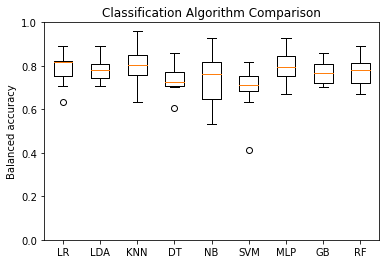

In [12]:
comp_bin_results = comp_bin(x,y)

In [13]:
comp_bin_df = pd.DataFrame(comp_bin_results)
comp_bin_df.to_csv('Data_files/For_plotting/model2_classification_method_comparison.csv')

## Recursive feature elimination for selected models

In [14]:
# defining array of number of features to test
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]
N_out = N.copy()
N_out.insert(0,len(x.columns))

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1841 0.788636 (0.115096)
 1:  1000 0.847727 (0.112767)
 2:   500 0.880606 (0.126810)
 3:   200 0.919242 (0.104079)
 4:   100 0.928788 (0.104466)
 5:    50 0.932121 (0.083594)
 6:    20 0.926364 (0.059158)
 7:    15 0.908485 (0.072481)
 8:    10 0.883182 (0.089446)
 9:     9 0.878636 (0.108854)
10:     8 0.873636 (0.083458)
11:     7 0.837879 (0.098029)
12:     6 0.856212 (0.078576)
13:     5 0.837424 (0.111738)
14:     4 0.806364 (0.117466)
15:     3 0.819394 (0.071485)
16:     2 0.831970 (0.084944)
17:     1 0.780303 (0.120842)

 Best number of descriptors =  50


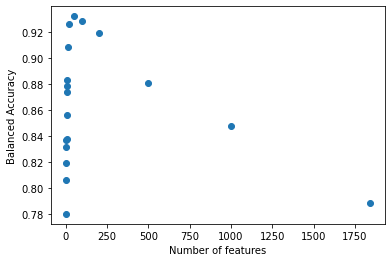

In [15]:
# Logistic regression
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# output scores to data file
LR_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LR_scores.to_csv('Data_files/For_plotting/model2_LR_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1841 0.743182 (0.112251)
 1:  1000 0.775455 (0.132162)
 2:   500 0.820000 (0.107597)
 3:   200 0.754697 (0.106059)
 4:   100 0.920606 (0.044728)
 5:    50 0.902727 (0.075231)
 6:    20 0.799545 (0.112265)
 7:    15 0.766667 (0.097877)
 8:    10 0.739242 (0.082696)
 9:     9 0.710000 (0.125456)
10:     8 0.719242 (0.117355)
11:     7 0.717121 (0.111101)
12:     6 0.588636 (0.118070)
13:     5 0.490455 (0.019118)
14:     4 0.495455 (0.013636)
15:     3 0.495455 (0.013636)
16:     2 0.495455 (0.013636)
17:     1 0.495455 (0.013636)

 Best number of descriptors =  100


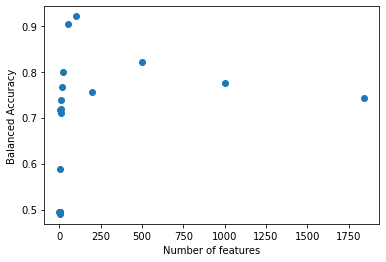

In [16]:
# Linear Discriminant Analysis
clf = LinearDiscriminantAnalysis()

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# output scores to data file
LDA_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LDA_scores.to_csv('Data_files/For_plotting/model2_LDA_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1841 0.771515 (0.081705)
 1:  1000 0.738182 (0.074245)
 2:   500 0.813485 (0.136585)
 3:   200 0.796061 (0.114672)
 4:   100 0.857273 (0.111702)
 5:    50 0.858030 (0.096398)
 6:    20 0.899242 (0.111197)
 7:    15 0.885455 (0.103962)
 8:    10 0.929242 (0.068417)
 9:     9 0.915909 (0.066288)
10:     8 0.927576 (0.057956)
11:     7 0.920909 (0.084748)
12:     6 0.897121 (0.082901)
13:     5 0.877576 (0.097475)
14:     4 0.844697 (0.094961)
15:     3 0.846818 (0.066056)
16:     2 0.810758 (0.093190)
17:     1 0.748333 (0.124647)

 Best number of descriptors =  10


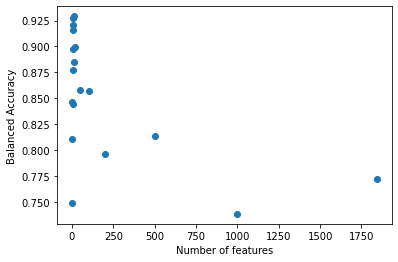

In [17]:
# Decision Tree
clf = DecisionTreeClassifier(class_weight='balanced',random_state=0)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# output scores to data file
DT_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
DT_scores.to_csv('Data_files/For_plotting/model2_DT_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1841 0.738636 (0.088304)
 1:  1000 0.779848 (0.070753)
 2:   500 0.796061 (0.057660)
 3:   200 0.812727 (0.059088)
 4:   100 0.816061 (0.097450)
 5:    50 0.866061 (0.079845)
 6:    20 0.873030 (0.097300)
 7:    15 0.869697 (0.104077)
 8:    10 0.850152 (0.106614)
 9:     9 0.856818 (0.092566)
10:     8 0.858485 (0.103675)
11:     7 0.865606 (0.097919)
12:     6 0.863485 (0.091313)
13:     5 0.873030 (0.087054)
14:     4 0.847727 (0.083713)
15:     3 0.833182 (0.107132)
16:     2 0.795758 (0.114277)
17:     1 0.622576 (0.078824)

 Best number of descriptors =  5


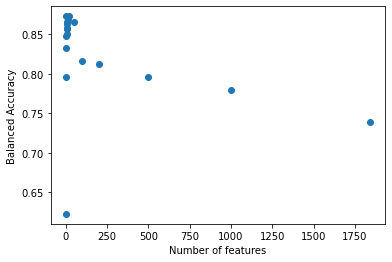

In [18]:
# Gradient Boosting
clf = GradientBoostingClassifier(random_state=0)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# output scores to data file
GB_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
GB_scores.to_csv('Data_files/For_plotting/model2_GB_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1841 0.746061 (0.084844)
 1:  1000 0.791818 (0.105606)
 2:   500 0.791818 (0.118582)
 3:   200 0.819697 (0.120557)
 4:   100 0.830152 (0.096425)
 5:    50 0.866364 (0.087719)
 6:    20 0.879697 (0.086221)
 7:    15 0.874394 (0.076851)
 8:    10 0.818939 (0.114827)
 9:     9 0.841818 (0.116385)
10:     8 0.846364 (0.104566)
11:     7 0.838030 (0.100546)
12:     6 0.840606 (0.079000)
13:     5 0.816818 (0.085633)
14:     4 0.801970 (0.123993)
15:     3 0.857727 (0.080647)
16:     2 0.808636 (0.143092)
17:     1 0.613030 (0.087166)

 Best number of descriptors =  20


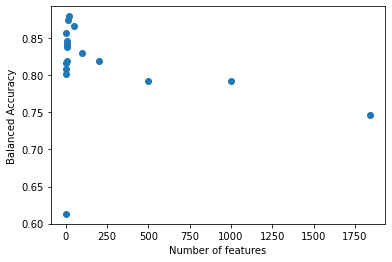

In [19]:
# Random Forest
clf = RandomForestClassifier(class_weight='balanced',random_state=0)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# output scores to data file
RF_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
RF_scores.to_csv('Data_files/For_plotting/model2_RF_scores.csv')

## Evaluating best model obtained through RFE with test compounds

In [20]:
# Logistic regression
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,X_train,Y_train,N,'RFE')

# using best N from above
N_best = 5

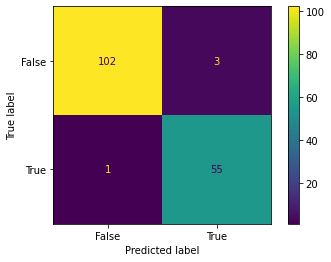

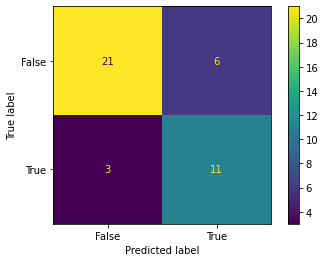

Balanced accuracy (train):  0.9767857142857143
Balanced accuracy (test):  0.7817460317460317
Recall (train):  0.9821428571428571
Recall (test):  0.7857142857142857
Precision (train):  0.9482758620689655
Precision (test):  0.6470588235294118


In [21]:
desc_sel = feat_r[N_best]

clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)

cm_test_train(clf,X_train[desc_sel],Y_train,X_test[desc_sel],Y_test)

# Correlation coefficients and single descriptor logistic regression

## Step 1

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Strongest postive correlation of  0.5225535330996902  for  ALOGP
Strongest postive correlation of  -0.5436076129793165  for  ESOL
  Descriptor  Abs (Point biserial r)       p value
0       ESOL                0.543608  6.282653e-17
1      ALOGP                0.522554  1.502896e-15
2      WiA_G                0.513395  5.591063e-15
3       DP11                0.512473  6.367749e-15
4       DP10                0.512436  6.401306e-15
5       DP09                0.512423  6.413412e-15
6       DP12                0.512291  6.533540e-15
7       DP08                0.512275  6.547596e-15
8       DP13                0.512191  6.625844e-15
9       DP07                0.511939  6.865017e-15


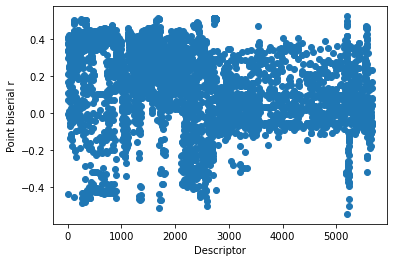

In [8]:
# Checking correlation of RG_binary with each of 5666 descriptors for entire dataset
[corr_coeffs,p_values] = point_biserial_correlation_data(data_aug,10)

# output correlation coeffients
data_aug_corr_coeffs = pd.DataFrame()
data_aug_corr_coeffs['Descriptor'] = data_aug.select_dtypes('number').columns
data_aug_corr_coeffs['corr_coeffs'] = corr_coeffs
data_aug_corr_coeffs['p_values'] = p_values
data_aug_corr_coeffs.to_csv('Data_files/For_plotting/data_aug_corr_coeffs.csv')

In [9]:
# Finding best descriptors for single feature logistic regression models for entire dataset
# and output balanced accuracy scores to csv
best_desc,desc_list,score_list = find_best_classifier(data_aug,20)
data_aug_clf_scores = pd.DataFrame()
data_aug_clf_scores['Descriptor'] = desc_list
data_aug_clf_scores['Balanced accuracy'] = score_list
data_aug_clf_scores.to_csv('Data_files/For_plotting/data_aug_clf_scores.csv')

      Descriptor  Balanced accuracy
0             Ti           0.751948
1           ESOL           0.750216
2            QED           0.749351
3          WiA_G           0.747294
4    SM06_EA(bo)           0.745563
5             Tu           0.744805
6    WHALES10_IR           0.743831
7        SpMAD_G           0.743506
8       SpPosA_G           0.743506
9       SpMaxA_G           0.743506
10  Eig03_EA(bo)           0.742965
11  SM13_AEA(ri)           0.742965
12           L1i           0.741450
13   SM04_EA(bo)           0.741342
14  Eig12_EA(bo)           0.740043
15   SM08_EA(bo)           0.737987
16        LOGP99           0.736364
17           IDE           0.734632
18           L1u           0.733874


In [10]:
# Calculate percentage of drugs with ALOGP greater than or equal to 8 that complex siRNA
sum(data_aug[data_aug['ALOGP']>=8.0]['RG_binary'])/len(data_aug[data_aug['ALOGP']>=8.0])*100

100.0

## Step 2

In [11]:
# Filtering for drugs with ALOGP < 8
data_aug_2 = data_aug[data_aug['ALOGP']<8.0]
data_aug_2

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.0,8.667,6.667,34.17,0.7765,9.000,0.20450,30.00,8.249,False
1,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,83905-01-5,Azithromycin,749.1,6.041,67.06,124.10,72.11,142.00,0.5408,...,0.0,0.000,0.000,48.08,0.9247,13.030,0.25050,58.19,15.960,False
2,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,55142-85-3,Ticlopidine,263.8,8.510,20.72,30.69,22.84,34.27,0.6685,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,False
3,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,59729-33-8,Citalopram,324.4,7.210,28.41,44.88,30.02,50.70,0.6313,...,0.0,6.000,6.000,15.00,0.6250,1.000,0.04167,9.11,1.732,False
4,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,159989-64-7,Nelfinavir,567.9,6.681,50.17,84.25,54.47,95.97,0.5903,...,1.2,3.600,9.600,35.10,0.8775,6.800,0.17000,37.32,7.605,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,CN1CCN(CC2=C(C=C(NC(=O)C3=CC(C#CC4=CC5=C(NN=C5...,-,HQP1351,532.6,8.070,43.31,67.08,44.44,75.20,0.6563,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,True
186,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,-,Apilimod,418.5,7.343,35.83,57.10,37.56,64.56,0.6285,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,True
187,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,-,Chlorpromazine,318.9,7.972,25.80,39.56,28.37,44.60,0.6450,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,False
189,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,-,Siramesine,454.6,6.994,41.04,64.30,43.82,72.77,0.6314,...,0.0,0.000,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,True


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Strongest postive correlation of  0.4836953154223196  for  nAB
Strongest postive correlation of  -0.4365779855181877  for  Yindex
      Descriptor  Abs (Point biserial r)       p value
0            nAB                0.483695  2.339340e-12
1            nAA                0.472176  8.962235e-12
2           nCar                0.469778  1.177960e-11
3            nBM                0.465828  1.839562e-11
4            PCD                0.459979  3.522218e-11
5   P_VSA_ppp_ar                0.453412  7.198002e-11
6      Eta_betaP                0.453028  7.501932e-11
7         Yindex                0.436578  4.201677e-10
8  P_VSA_ppp_cyc                0.435473  4.701812e-10
9           HOMT                0.434317  5.286316e-10


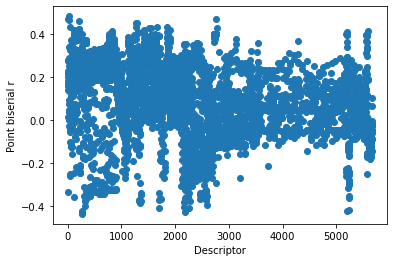

In [12]:
# Checking correlation of RG_binary with each of 5666 descriptors for ALOGP < 8
[corr_coeffs,p_values] = point_biserial_correlation_data(data_aug_2,10)

# output correlation coeffients
data_aug2_corr_coeffs = pd.DataFrame()
data_aug2_corr_coeffs['Descriptor'] = data_aug_2.select_dtypes('number').columns
data_aug2_corr_coeffs['corr_coeffs'] = corr_coeffs
data_aug2_corr_coeffs['p_values'] = p_values
data_aug2_corr_coeffs.to_csv('Data_files/For_plotting/data_aug2_corr_coeffs.csv')

In [13]:
# Finding best descriptors for single feature logistic regression models for ALOGP < 8.0
# and output balanced accuracy scores to csv
best_desc,desc_list,score_list = find_best_classifier(data_aug_2,10)
data_aug2_clf_scores = pd.DataFrame()
data_aug2_clf_scores['Descriptor'] = desc_list
data_aug2_clf_scores['Balanced accuracy'] = score_list
data_aug2_clf_scores.to_csv('Data_files/For_plotting/data_aug2_clf_scores.csv')

  Descriptor  Balanced accuracy
0        nAB           0.760606
1        nAA           0.760606
2     piPC08           0.756061
3       DECC           0.746970
4       nCb-           0.746212
5       HOMT           0.745455
6     piPC10           0.744697
7     TDB07v           0.740909
8        nBM           0.740152


In [14]:
# Calculate percentage of drugs with nAB <= 12 that complex siRNA
sum(data_aug_2[data_aug_2['nAB']<=12]['RG_binary'])/len(data_aug_2[data_aug_2['nAB']<=12])*100

3.79746835443038

## Step 3

In [15]:
# Filtering for drugs with nAB > 12
data_aug_3 = data_aug_2[data_aug_2['nAB']>12]
data_aug_3

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.000,8.667,6.667,34.17,0.7765,9.0,0.2045,30.00,8.249,False
5,CC(C)(C)NC(=O)[C@@H]1CN(CC2=CN=CC=C2)CCN1C[C@@...,150378-17-9,Indinavir,613.9,6.673,55.03,91.37,58.84,104.00,0.5981,...,1.200,5.200,11.200,40.20,0.8933,8.0,0.1778,47.77,10.310,False
6,ClC1=CC(Cl)=C(CO\N=C(/CN2C=CN=C2)C2=CC=C(Cl)C=...,64211-45-6,Oxiconazole,429.1,11.000,28.78,40.11,30.23,43.39,0.7379,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,False
8,ClC1=CC=CC=C1C(N1C=CN=C1)(C1=CC=CC=C1)C1=CC=CC=C1,23593-75-1,Clotrimazole,344.9,8.211,29.08,41.60,30.96,46.26,0.6925,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,False
13,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)...,511-12-6,Dihydroergotamine,583.8,7.297,50.11,80.28,52.48,90.18,0.6264,...,1.143,7.143,10.000,36.29,0.8439,8.5,0.1977,38.60,10.320,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,CC1=CC(=CC=C1)N2CCN(CCC3=CC=C4C=CC=CC4=N3)CC2,-,Centhaquine,331.5,6.630,30.86,49.03,33.39,56.06,0.6172,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,False
184,COC1=CC=C2C(OC3=CC4=CC=CC(C(=O)NC5=CC=CC=C5N)=...,-,Chiauranib,435.5,8.065,36.95,54.24,38.23,59.86,0.6843,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True
185,CN1CCN(CC2=C(C=C(NC(=O)C3=CC(C#CC4=CC5=C(NN=C5...,-,HQP1351,532.6,8.070,43.31,67.08,44.44,75.20,0.6563,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True
186,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,-,Apilimod,418.5,7.343,35.83,57.10,37.56,64.56,0.6285,...,0.000,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Strongest postive correlation of  0.3941917710558867  for  DISPv
Strongest postive correlation of  -0.3228241635401498  for  GATS5v
        Descriptor  Abs (Point biserial r)   p value
0            DISPv                0.394192  0.000024
1            DISPp                0.383265  0.000042
2           MATS5v                0.361999  0.000118
3           GATS5v                0.322824  0.000655
4              ICR                0.321772  0.000684
..             ...                     ...       ...
255      Chi_Dz(p)                0.215192  0.025313
256   SpMax3_Bh(v)                0.215190  0.025314
257            nAA                0.215016  0.025436
258  VE2sign_Dz(i)                0.214988  0.025456
259          nArOR                0.214532  0.025777

[260 rows x 3 columns]


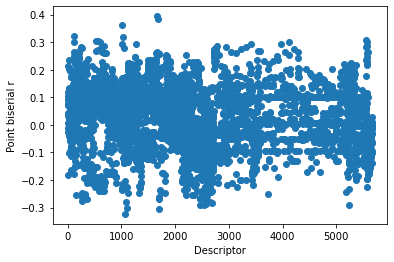

In [16]:
# Checking correlation of RG_binary with each of 5666 descriptors for ALOGP < 8 & nAB > 12
[corr_coeffs,p_values] = point_biserial_correlation_data(data_aug_3,260)

# output correlation coeffients
data_aug3_corr_coeffs = pd.DataFrame()
data_aug3_corr_coeffs['Descriptor'] = data_aug_3.select_dtypes('number').columns
data_aug3_corr_coeffs['corr_coeffs'] = corr_coeffs
data_aug3_corr_coeffs['p_values'] = p_values
data_aug3_corr_coeffs.to_csv('Data_files/For_plotting/data_aug3_corr_coeffs.csv')

In [17]:
# Finding best descriptors for single feature logistic regression models for ALOGP < 8.0 & nAB > 12
# and output balanced accuracy scores to csv
best_desc,desc_list,score_list = find_best_classifier(data_aug_3,20)
data_aug3_clf_scores = pd.DataFrame()
data_aug3_clf_scores['Descriptor'] = desc_list
data_aug3_clf_scores['Balanced accuracy'] = score_list
data_aug3_clf_scores.to_csv('Data_files/For_plotting/data_aug3_clf_scores.csv')

       Descriptor  Balanced accuracy
0          GATS5v           0.703297
1            nCb-           0.692995
2           DISPv           0.692308
3   WHALES90_Isol           0.684753
4          MATS5p           0.684066
5           nArOR           0.683379
6          piPC06           0.677885
7            JGI3           0.677885
8          MATS5v           0.675824
9            DECC           0.675137
10          DISPp           0.674451
11         MATS5i           0.668956
12          WiA_G           0.665522
13       SpPosA_G           0.665522
14       SpMaxA_G           0.665522
15        SpMAD_G           0.665522
16         HATS6e           0.660027
17         piPC07           0.659341
18            ICR           0.658654


In [18]:
# adding a descriptor for the presence of a nitrogen or oxygen containing aromatic ring
data_aug_3['NOArRing'] =  (
    (data_aug_3['nArOR']>0)|
    (data_aug_3['nArOH']>0)|
    (data_aug_3['nArOCN']>0)|
    (data_aug_3['nArNCO']>0)|
    (data_aug_3['nArNCS']>0)|
    (data_aug_3['nArOCON']>0)|
    (data_aug_3['nArNHO']>0)|
    (data_aug_3['nArNNOx']>0)|
    (data_aug_3['nArNO']>0)|
    (data_aug_3['nArNO2']>0)|
    (data_aug_3['nArOX']>0)|
    (data_aug_3['nFuranes']>0)|
    (data_aug_3['nOxazoles']>0)|
    (data_aug_3['nIsoxazoles']>0)|
    (data_aug_3['nArNH2']>0) |
    (data_aug_3['nArNHR']>0) |
    (data_aug_3['nArNR2']>0) |
    (data_aug_3['nPyrroles']>0) |
    (data_aug_3['nPyrazoles']>0) |
    (data_aug_3['nImidazoles']>0) |
    (data_aug_3['nThiazoles']>0) |
    (data_aug_3['nIsothiazoles']>0) |
    (data_aug_3['nTriazoles']>0) |
    (data_aug_3['nPyridines']>0) |
    (data_aug_3['nPyridazines']>0) |
    (data_aug_3['nPyrimidines']>0) |
    (data_aug_3['nPyrazines']>0) |
    (data_aug_3['n135-Triazines']>0) |
    (data_aug_3['n124-Triazines']>0)
)

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
# reshuffle so the RG_binary is the last column
data_aug_3 = data_aug_3[[c for c in data_aug_3 if c not in ['RG_binary']] 
       + ['RG_binary']]
data_aug_3

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,NOArRing,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,8.667,6.667,34.17,0.7765,9.0,0.2045,30.00,8.249,True,False
5,CC(C)(C)NC(=O)[C@@H]1CN(CC2=CN=CC=C2)CCN1C[C@@...,150378-17-9,Indinavir,613.9,6.673,55.03,91.37,58.84,104.00,0.5981,...,5.200,11.200,40.20,0.8933,8.0,0.1778,47.77,10.310,True,False
6,ClC1=CC(Cl)=C(CO\N=C(/CN2C=CN=C2)C2=CC=C(Cl)C=...,64211-45-6,Oxiconazole,429.1,11.000,28.78,40.11,30.23,43.39,0.7379,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
8,ClC1=CC=CC=C1C(N1C=CN=C1)(C1=CC=CC=C1)C1=CC=CC=C1,23593-75-1,Clotrimazole,344.9,8.211,29.08,41.60,30.96,46.26,0.6925,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
13,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)...,511-12-6,Dihydroergotamine,583.8,7.297,50.11,80.28,52.48,90.18,0.6264,...,7.143,10.000,36.29,0.8439,8.5,0.1977,38.60,10.320,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,CC1=CC(=CC=C1)N2CCN(CCC3=CC=C4C=CC=CC4=N3)CC2,-,Centhaquine,331.5,6.630,30.86,49.03,33.39,56.06,0.6172,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
184,COC1=CC=C2C(OC3=CC4=CC=CC(C(=O)NC5=CC=CC=C5N)=...,-,Chiauranib,435.5,8.065,36.95,54.24,38.23,59.86,0.6843,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True
185,CN1CCN(CC2=C(C=C(NC(=O)C3=CC(C#CC4=CC5=C(NN=C5...,-,HQP1351,532.6,8.070,43.31,67.08,44.44,75.20,0.6563,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True
186,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,-,Apilimod,418.5,7.343,35.83,57.10,37.56,64.56,0.6285,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True


In [20]:
# Calculate percentage of drugs with NOArRing = 0 that complex siRNA
sum(data_aug_3[data_aug_3['NOArRing']==0]['RG_binary'])/len(data_aug_3[data_aug_3['NOArRing']==0])*100

18.181818181818183

In [21]:
data_aug_3[data_aug_3['NOArRing']==0]

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,NOArRing,RG_binary
26,C(C=CC1=CC=CC=C1)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC...,298-57-7,Cinnarizine,368.6,6.581,34.89,54.69,37.91,62.39,0.6231,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00,0.000,False,False
36,CN(CC=CC1=CC=CC=C1)CC1=CC=CC2=CC=CC=C12,65472-88-0,Naftifine,287.4,6.684,27.29,41.94,29.62,47.65,0.6346,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00,0.000,False,False
48,CC(C)(C(O)=O)C1=CC=C(C=C1)C(O)CCCN1CCC(CC1)C(O...,83799-24-0,Fexofenadine,501.7,6.602,45.89,75.20,49.29,85.22,0.6038,...,6.0,12.0,35.0,0.9459,4.0,0.10810,37.42,3.317,False,False
52,C[C@@H](NCCCC1=CC(=CC=C1)C(F)(F)F)C1=CC=CC2=CC...,226256-56-0,Cinacalcet,357.5,7.447,30.49,48.24,31.95,54.50,0.6353,...,11.0,6.0,24.0,0.9231,1.0,0.03846,23.73,1.732,False,False
55,CN(CC1=CC=C(C=C1)C(C)(C)C)CC1=CC=CC2=CC=CC=C12,101828-21-1,Butenafine,317.5,6.226,30.87,49.59,33.90,56.90,0.6053,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00,0.000,False,False
93,FC(F)(F)CNC(=O)C1(CCCCN2CCC(CC2)NC(=O)C2=C(C=C...,182431-12-5,Lomitapide,693.8,7.975,56.33,88.71,57.78,99.26,0.6475,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00,0.000,False,False
122,CC(C)(C)C1=CC=C(C=C1)C(O)CCCN2CCC(CC2)C(O)(C3=...,-,Terfenadine,471.7,6.207,44.99,74.43,49.14,85.22,0.5919,...,6.0,12.0,33.0,0.9429,2.0,0.05714,36.93,3.317,False,False
123,CC(C)(C)C1=CC=C(CN2CCN(CC2)C(C3=CC=CC=C3)C4=CC...,-,Buclizine,433.1,6.767,39.30,62.66,43.05,71.58,0.6140,...,6.0,6.0,24.0,0.7742,2.0,0.06452,24.41,3.464,False,True
136,CN(CC(CCN1CCC(CC1)(NC(C)=O)C2=CC=CC=C2)C3=CC=C...,-,Saredutant,552.6,7.570,46.10,72.63,49.59,81.86,0.6316,...,6.0,6.0,29.0,0.7632,5.0,0.13160,25.83,5.196,False,False
140,CC(NCCC(C1=CC=CC=C1)C2=CC=CC=C2)C3=CC=CC=C3,-,Fendiline,315.5,6.439,30.34,47.71,33.14,54.48,0.6192,...,6.0,12.0,22.0,0.9167,1.0,0.04167,25.36,1.732,False,False


## Step 4

In [22]:
# Filtering for drugs with NOArRing > 0
data_aug_4 = data_aug_3[(data_aug_3['NOArRing']>0)]
data_aug_4

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,NOArRing,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,8.667,6.667,34.17,0.7765,9.0,0.2045,30.00,8.249,True,False
5,CC(C)(C)NC(=O)[C@@H]1CN(CC2=CN=CC=C2)CCN1C[C@@...,150378-17-9,Indinavir,613.9,6.673,55.03,91.37,58.84,104.00,0.5981,...,5.200,11.200,40.20,0.8933,8.0,0.1778,47.77,10.310,True,False
6,ClC1=CC(Cl)=C(CO\N=C(/CN2C=CN=C2)C2=CC=C(Cl)C=...,64211-45-6,Oxiconazole,429.1,11.000,28.78,40.11,30.23,43.39,0.7379,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
8,ClC1=CC=CC=C1C(N1C=CN=C1)(C1=CC=CC=C1)C1=CC=CC=C1,23593-75-1,Clotrimazole,344.9,8.211,29.08,41.60,30.96,46.26,0.6925,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
13,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)...,511-12-6,Dihydroergotamine,583.8,7.297,50.11,80.28,52.48,90.18,0.6264,...,7.143,10.000,36.29,0.8439,8.5,0.1977,38.60,10.320,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,CC1=CC(=CC=C1)N2CCN(CCC3=CC=C4C=CC=CC4=N3)CC2,-,Centhaquine,331.5,6.630,30.86,49.03,33.39,56.06,0.6172,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,False
184,COC1=CC=C2C(OC3=CC4=CC=CC(C(=O)NC5=CC=CC=C5N)=...,-,Chiauranib,435.5,8.065,36.95,54.24,38.23,59.86,0.6843,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True
185,CN1CCN(CC2=C(C=C(NC(=O)C3=CC(C#CC4=CC5=C(NN=C5...,-,HQP1351,532.6,8.070,43.31,67.08,44.44,75.20,0.6563,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True
186,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,-,Apilimod,418.5,7.343,35.83,57.10,37.56,64.56,0.6285,...,0.000,0.000,0.00,0.0000,0.0,0.0000,0.00,0.000,True,True


/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Strongest postive correlation of  0.386811197892046  for  DISPv
Strongest postive correlation of  -0.461477151598055  for  WHALES90_Isol
      Descriptor  Abs (Point biserial r)   p value
0  WHALES90_Isol                0.461477  0.000002
1  WHALES80_Isol                0.412111  0.000027
2    WHALES90_IR                0.387136  0.000090
3          DISPv                0.386811  0.000091
4          DISPp                0.386495  0.000092
5    WHALES80_IR                0.384351  0.000102
6   CATS2D_02_DL                0.347835  0.000481
7           JGI3                0.338912  0.000685
8          Chi_G                0.335649  0.000777
9  VE1sign_Dz(m)                0.333548  0.000842


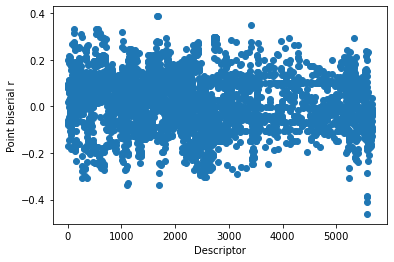

In [23]:
# Checking correlation of RG_binary with each of 5666 descriptors for ALOGP < 8, nAB > 12 & NOArRing > 0
[corr_coeffs,p_values] = point_biserial_correlation_data(data_aug_4,10)

# Output correlation coefficients
data_aug4_corr_coeffs = pd.DataFrame()
data_aug4_corr_coeffs['Descriptor'] = data_aug_4.select_dtypes('number').columns
data_aug4_corr_coeffs['corr_coeffs'] = corr_coeffs
data_aug4_corr_coeffs['p_values'] = p_values
data_aug4_corr_coeffs.to_csv('Data_files/For_plotting/data_aug4_corr_coeffs.csv')

In [24]:
# Finding best descriptors for single feature logistic regression models for ALOGP < 8, nAB > 12 & NOArRing > 0
# and output balanced accuracy scores to csv
best_desc,desc_list,score_list = find_best_classifier(data_aug_4,20)
data_aug4_clf_scores = pd.DataFrame()
data_aug4_clf_scores['Descriptor'] = desc_list
data_aug4_clf_scores['Balanced accuracy'] = score_list
data_aug4_clf_scores.to_csv('Data_files/For_plotting/data_aug4_clf_scores.csv')

       Descriptor  Balanced accuracy
0   WHALES90_Isol           0.710426
1           DISPv           0.702979
2    CATS2D_02_DL           0.691702
3           DISPp           0.681702
4            nCb-           0.681064
5    CATS3D_02_DL           0.680426
6   WHALES80_Isol           0.680426
7     WHALES90_IR           0.679787
8            JGI3           0.678511
9   VE1sign_Dz(Z)           0.672979
10  VE1sign_Dz(m)           0.672979
11       SpMaxA_G           0.671064
12          WiA_G           0.671064
13        SpMAD_G           0.671064
14       SpPosA_G           0.671064
15           DECC           0.671064
16          nArOR           0.670426
17   VE1sign_D/Dt           0.661702
18          HVcpx           0.659787


## Classification model

In [25]:
# Remove features with variance below threshold or correlated to each other

# Threshold for variance
threshold = 0;
X = data_aug_4.select_dtypes(include='number');

scaler = preprocessing.MinMaxScaler()

X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

selector = VarianceThreshold(threshold)
selector.fit(X)
X_reduced = X_scaled[X_scaled.columns[selector.get_support(indices=True)]]

# Correlation matrix
corr_matrix = X_reduced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_reduced = X_reduced.drop(to_drop, axis=1)

# Y is binary classification
Y = data_aug_4['RG_binary']

In [26]:
# Set the x (descriptors) and y (output) for the model
x=X_reduced
y=Y

In [27]:
# Split x and y into stratified train and test sets (20% test)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True,stratify=y)

In [28]:
# Extract CATS and WHALES features and a combined set
CATS_feat = X_train.filter(like='CATS').columns
WHALES_feat = X_train.filter(like='WHALES').columns
WHALECAT_feat = WHALES_feat.union(CATS_feat)

   Balanced accuracy (SD)
   LR: 0.629167 (0.206197)
  LDA: 0.479167 (0.285804)
  KNN: 0.570833 (0.194588)
   DT: 0.600000 (0.149304)
   NB: 0.516667 (0.081650)
  SVM: 0.500000 (0.000000)
  MLP: 0.616667 (0.202244)
   GB: 0.625000 (0.144338)
   RF: 0.716667 (0.121906)


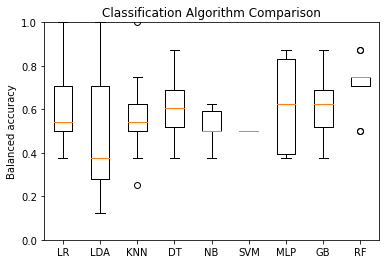

In [29]:
# Compare classification models with cross validation using CATS and WHALES features
comp_bin_results = comp_bin(X_train[WHALECAT_feat],Y_train)

In [30]:
# Output results of binary classification method comparison 
pd.DataFrame(comp_bin_results).to_csv('Data_files/For_plotting/comb_bin_WHALECAT.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:   242 0.725000 (0.160511)
 1:   200 0.725000 (0.163724)
 2:   100 0.645833 (0.143433)
 3:    50 0.691667 (0.148137)
 4:    20 0.787500 (0.086301)
 5:    15 0.812500 (0.083853)
 6:    10 0.725000 (0.098953)
 7:     9 0.737500 (0.103833)
 8:     8 0.775000 (0.087797)
 9:     7 0.762500 (0.103833)
10:     6 0.825000 (0.076376)
11:     5 0.750000 (0.116369)
12:     4 0.737500 (0.113422)
13:     3 0.725000 (0.145774)
14:     2 0.625000 (0.164570)
15:     1 0.633333 (0.144097)
Best number of descriptors =  6


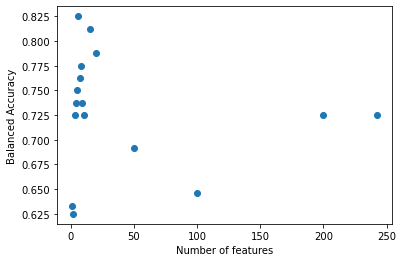

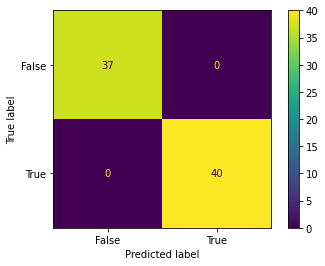

Balanced accuracy:  1.0


In [31]:
# Array of number of features to try
N = [200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]

# Selecting best classifier from above
clf = RandomForestClassifier(random_state=0)

# Employing recursive feature elimination with WHALES and CATS features
feat_r = multi_feat_red(clf,X_train[WHALECAT_feat],Y_train,N,'RFE')

# Comparing scores for features and storing values
N_best,scores,stdevs = feat_comp(clf,feat_r,X_train,Y_train,len(WHALECAT_feat))

# Printing best number of descriptors and displaying confusion matrix
print('Best number of descriptors = ',N[N_best])
cm_test(clf,X_train[feat_r[N_best+1]],Y_train)

In [32]:
N_best

9

In [33]:
# Defining DataFrame to store recursive feature elimination on Random Forest model and exporting to csv
RF_RFE = pd.DataFrame()
N_aug = [242,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]
RF_RFE['N'] = N_aug
RF_RFE['Balanced accuracy'] = scores
RF_RFE['SD'] = stdevs
RF_RFE.to_csv('Data_Files/For_plotting/data_aug_4_RF_RFE.csv')

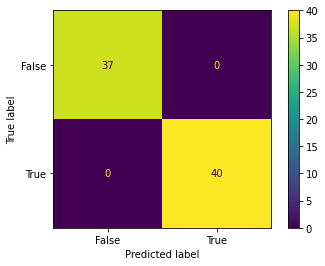

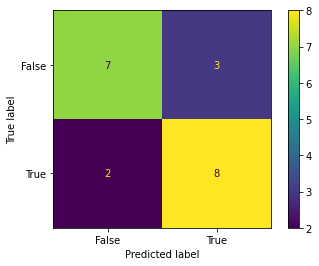

Balanced accuracy (train):  1.0
Balanced accuracy (test):  0.75
Recall (train):  1.0
Recall (test):  0.8
Precision (train):  1.0
Precision (test):  0.7272727272727273


In [34]:
# Defining Random Forest classification model
clf = RandomForestClassifier(random_state=0)

# selecting best descriptor set from RFE
desc_sel = feat_r[N_best+1]

# Displaying confusion matrix for best results
cm_test_train(clf,X_train[desc_sel],Y_train,X_test[desc_sel],Y_test)

In [35]:
# Permutation importance to rank features

# Defining Random Forest classification model
clf = RandomForestClassifier(random_state=0)
# selecting best descriptor set from RFE
desc_sel = feat_r[N_best+1]

clf.fit(X_train[desc_sel],Y_train)

r = permutation_importance(clf, X_train[desc_sel], Y_train*1,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - r.importances_std[i] > 0:
         print(f"{X_train[desc_sel].columns[i]:<15}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

WHALES90_Isol  0.155 +/- 0.034
CATS2D_05_AL   0.087 +/- 0.026
CATS3D_12_LL   0.081 +/- 0.018
CATS3D_02_AL   0.067 +/- 0.018
WHALES80_Isol  0.026 +/- 0.015


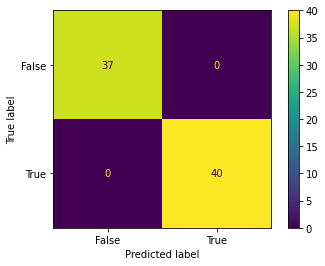

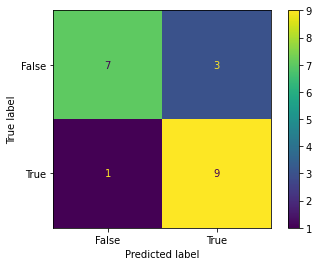

Balanced accuracy (train):  1.0
Balanced accuracy (test):  0.8
Recall (train):  1.0
Recall (test):  0.9
Precision (train):  1.0
Precision (test):  0.75


In [36]:
clf = RandomForestClassifier(random_state=0)

desc_sel = ['WHALES90_Isol','CATS2D_05_AL','CATS3D_12_LL','CATS3D_02_AL','WHALES80_Isol']
cm_test_train(clf,X_train[desc_sel],Y_train,X_test[desc_sel],Y_test)

In [37]:
desc_sel = ['WHALES90_Isol','CATS2D_05_AL','CATS3D_12_LL','CATS3D_02_AL','WHALES80_Isol']
r = permutation_importance(clf, X_train[desc_sel], Y_train*1,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - r.importances_std[i] > 0:
         print(f"{X_train[desc_sel].columns[i]:<20}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

WHALES90_Isol       0.223 +/- 0.039
CATS2D_05_AL        0.133 +/- 0.029
CATS3D_12_LL        0.120 +/- 0.019
CATS3D_02_AL        0.093 +/- 0.022
WHALES80_Isol       0.062 +/- 0.022


# Example drugs to test model

In [41]:
# read file with descriptors
example_drugs = pd.read_csv('Data_files/descriptors_example_cases.csv')
example_drugs[['NAME','CMC-80','ALOGP','AMR','nAB']]

,NAME,CMC-80,ALOGP,AMR,nAB
0,Emetine analog,0,13.210,229.0,12
1,Netarsudil,0,3.901,132.4,23
2,Sorafenib analogue,0,3.938,127.9,23


In [39]:
# Use classification model to predict siRNA complexation by example drugs
example_drugs[X.columns]=scaler.transform(example_drugs[X.columns])
clf.predict(example_drugs[desc_sel])

array([ True,  True,  True])

# Export classification model

In [48]:
# export model as pickle file
pickle.dump(clf, open('Data_files/siRNA_complexation_classifier.pkl', 'wb'))

# export scaler for model as pickle file
pickle.dump(scaler, open('Data_files/siRNA_complexation_classifier_scaler.pkl', 'wb'))

# export names of all descriptors as pickle file
pickle.dump(X.columns, open('Data_files/siRNA_complexation_classifier_descriptors_all.pkl', 'wb'))

# export names of descriptors in model as pickle file
pickle.dump(desc_sel, open('Data_files/siRNA_complexation_classifier_descriptors_model.pkl', 'wb'))